# Linear Regression Exploration

I am walking through this again with fresh eyes to see if I can get a better score than when I first submitted this in the kaggle competition.
<hr>

These are my dependencies; the first four are for manipulating and plotting the data. I don't want to use seaborn, but it's really handy for heatmaps and pairplots which I may need later on.

The rest are for the linear regression modeling. I should probably take a look at a few other models (most notably Gradient Boost and Adaboost), but can add those later on.

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

## 1. Reading and cleaning data

I need to get rid of features where there are just too many null values. These don't help with predicting prices; they are noise (at least that is my assumption).

In [61]:
df = pd.read_csv('../data/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [63]:
df.shape

(2051, 81)

In [65]:
df.isnull().sum()[df.isnull().sum() > 0]

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

I want to drop features with 1000ish missing values. This will get the column values that I will want to drop

In [66]:
columns_to_drop = df.isnull().sum()[df.isnull().sum() > 330].index.tolist()

In [67]:
df.drop(columns=columns_to_drop, inplace=True)

In [68]:
df.shape

(2051, 76)

I will take another look at the features with null values and see how I can fill these in.

In [69]:
df.isnull().sum()[df.isnull().sum() > 0]

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Qual          55
Bsmt Cond          55
Bsmt Exposure      58
BsmtFin Type 1     55
BsmtFin SF 1        1
BsmtFin Type 2     56
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Type       113
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
Garage Qual       114
Garage Cond       114
dtype: int64

In [70]:
columns_with_nulls = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

Taking a look at the types, I think I want to look at the object values and just default nan's in the float64 columns to 0 (I had looked at the values and this seemed sensible).

In [71]:
df[columns_with_nulls].dtypes

Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Cars       float64
Garage Area       float64
Garage Qual        object
Garage Cond        object
dtype: object

In [91]:
for col in df[columns_with_nulls].select_dtypes("float64").columns.tolist():
    df[col].fillna(0, inplace=True)

In [56]:
for col in df[columns_with_nulls].select_dtypes("object").columns:
    print(col)
    print()
    print(f"Null Count: {df[col].isnull().sum()}")
    print()
    print(df[col].sort_values().unique())
    [print() for _ in range(3)]

Mas Vnr Type

Null Count: 22

['BrkCmn' 'BrkFace' 'None' 'Stone' nan]



Bsmt Qual

Null Count: 55

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Bsmt Cond

Null Count: 55

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Bsmt Exposure

Null Count: 58

['Av' 'Gd' 'Mn' 'No' nan]



BsmtFin Type 1

Null Count: 55

['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf' nan]



BsmtFin Type 2

Null Count: 56

['ALQ' 'BLQ' 'GLQ' 'LwQ' 'Rec' 'Unf' nan]



Garage Type

Null Count: 113

['2Types' 'Attchd' 'Basment' 'BuiltIn' 'CarPort' 'Detchd' nan]



Garage Finish

Null Count: 114

['Fin' 'RFn' 'Unf' nan]



Garage Qual

Null Count: 114

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]



Garage Cond

Null Count: 114

['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]





It looks like some of these can have similar values and I can probably replace these values with numerical values after some exploratory data analysis.

In [78]:
df['Mas Vnr Type'].fillna("None", inplace=True)

In [87]:
string_cols = [
    'Bsmt Qual', 
    'Bsmt Cond', 
    'Garage Qual', 
    'Garage Cond', 
    'Garage Finish', 
    'Garage Type', 
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2'
]

for val in string_cols:
    df[val].fillna("NA", inplace=True)

In [95]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

Going to check for out of bound values now...

In [127]:
set(df.dtypes.values)

{dtype('int64'), dtype('O')}

Going to see if I can cast the floats to integers instead.

In [118]:
df.select_dtypes("float64")[df.select_dtypes("float64").applymap(lambda x: x.is_integer()) == False].count()

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
Garage Cars       0
Garage Area       0
dtype: int64

In [125]:
for col in df.select_dtypes("float64").columns.tolist():
    df[col] = df[col].astype("int64")

In [126]:
for col in df.select_dtypes("int64").columns.tolist():
    print(f"Min of {col}: {df[col].min()}")
    print(f"Max of {col}: {df[col].max()}")
    [print() for _ in range(3)]

Min of Id: 1
Max of Id: 2930



Min of PID: 526301100
Max of PID: 924152030



Min of MS SubClass: 20
Max of MS SubClass: 190



Min of Lot Frontage: 0
Max of Lot Frontage: 313



Min of Lot Area: 1300
Max of Lot Area: 159000



Min of Overall Qual: 1
Max of Overall Qual: 10



Min of Overall Cond: 1
Max of Overall Cond: 9



Min of Year Built: 1872
Max of Year Built: 2010



Min of Year Remod/Add: 1950
Max of Year Remod/Add: 2010



Min of Mas Vnr Area: 0
Max of Mas Vnr Area: 1600



Min of BsmtFin SF 1: 0
Max of BsmtFin SF 1: 5644



Min of BsmtFin SF 2: 0
Max of BsmtFin SF 2: 1474



Min of Bsmt Unf SF: 0
Max of Bsmt Unf SF: 2336



Min of Total Bsmt SF: 0
Max of Total Bsmt SF: 6110



Min of 1st Flr SF: 334
Max of 1st Flr SF: 5095



Min of 2nd Flr SF: 0
Max of 2nd Flr SF: 1862



Min of Low Qual Fin SF: 0
Max of Low Qual Fin SF: 1064



Min of Gr Liv Area: 334
Max of Gr Liv Area: 5642



Min of Bsmt Full Bath: 0
Max of Bsmt Full Bath: 3



Min of Bsmt Half Bath: 0
Max of Bsmt Half

Going to drop row where the "Garage Yr Blt" value is greater than 2010.

In [135]:
df.drop(df[df['Garage Yr Blt'] > 2010].index, inplace=True)

Going to also drop "Id" and "PID" as these are not really helpful (I think)

In [137]:
df.drop(columns=["Id","PID"], inplace=True)

Going to drop an observation where the remodel year happens before the year built:

In [141]:
df.drop(df[df['Year Built'] > df['Year Remod/Add']].index, inplace=True)

There is a really old house that has a large SalePrice, going to drop it because it's an outlier

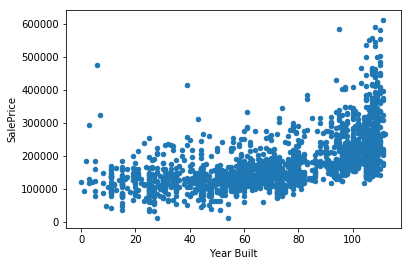

In [263]:
df.plot(kind='scatter', x="Year Built", y="SalePrice")

In [273]:
df.drop(df[(df['Year Built'] < 65) & (df['SalePrice'] > 280000)].index, inplace=True)

## 2. Feature Engineering and Exploration

Now I am going to look at some features and see how they may impact the sales price. Going to also engineer some along the way to tease out some linear relationships.

According to the [data dictionary](https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge/data), the "YearRemodAdd" will use the 'same ... construction date if no remodeling or additions'. These means we can identify houses that haven't been remodeled.

In [274]:
df["Remodeled"] = 0

In [275]:
df[df['Year Built'] == df['Year Remod/Add']].shape

(6, 76)

Going to add up the total area of the houses as a feature.

In [276]:
def add_up_square_feet(data_frame):
    # Set an initital value
    data_frame["total_square_feet"] = 0

    # Add up the values from the other columns minus the total column
    for col in [col for col in data_frame.columns if " SF" in col or col == "LotArea"]:
        data_frame["total_square_feet"] += data_frame[col]
        

# retrieve the first 5 columns
add_up_square_feet(df)


df["total_square_feet"].head()

0    2973
1    4022
2    3223
3    2312
4    2856
Name: total_square_feet, dtype: int64

In [277]:
df.loc[df['Year Built'] < df['Year Remod/Add'], "Remodeled"] = 1

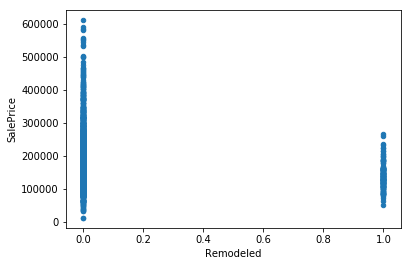

In [278]:
df[["Remodeled","SalePrice"]].plot(kind="scatter", x="Remodeled",y="SalePrice")

I am going to square the year values so that if there are any linear relationships, they should be stronger

In [279]:
yr_columns = ['Year Built','Yr Sold','Year Remod/Add','Garage Yr Blt']
df[yr_columns] =  df[yr_columns].applymap(lambda x: x**2)

Going to take a look at the object columns and see if I can reengineer them into something a but more usable.

In [280]:
le = LabelEncoder()
for col in df.select_dtypes('object').columns.tolist():
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

In [281]:
set(df.dtypes.values)

{dtype('int64')}

In [282]:
# https://stackoverflow.com/questions/34896455/how-to-do-pearson-correlation-of-selected-columns-of-a-pandas-data-frame
sp_corr = df[df.columns[1:]].corr()['SalePrice'][:-1]

In [283]:
most_correlated = sp_corr[ (sp_corr > .5) | (sp_corr < -.5)]
most_correlated

Overall Qual      0.802148
Year Built        0.638238
Year Remod/Add    0.557708
Mas Vnr Area      0.512352
Exter Qual       -0.663148
Bsmt Qual        -0.591844
Total Bsmt SF     0.633003
1st Flr SF        0.619822
Gr Liv Area       0.693804
Full Bath         0.535306
Kitchen Qual     -0.633206
Garage Yr Blt     0.610622
Garage Cars       0.649120
Garage Area       0.648935
SalePrice         1.000000
Name: SalePrice, dtype: float64

c:\python36\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 864x864 with 0 Axes>

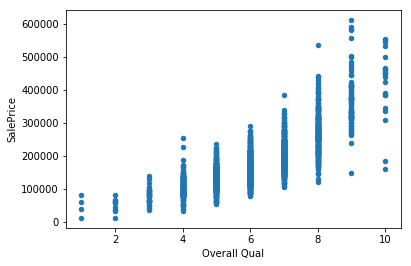

<Figure size 864x864 with 0 Axes>

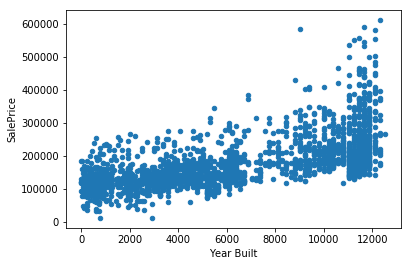

<Figure size 864x864 with 0 Axes>

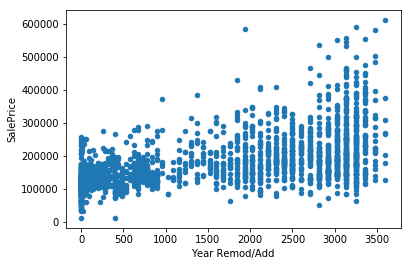

<Figure size 864x864 with 0 Axes>

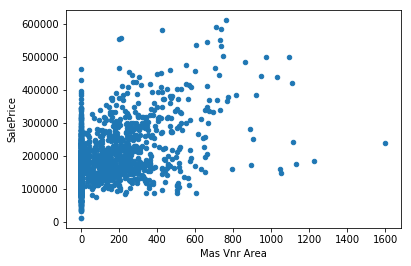

<Figure size 864x864 with 0 Axes>

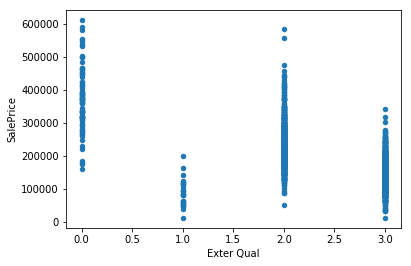

<Figure size 864x864 with 0 Axes>

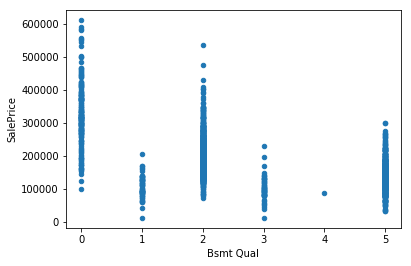

<Figure size 864x864 with 0 Axes>

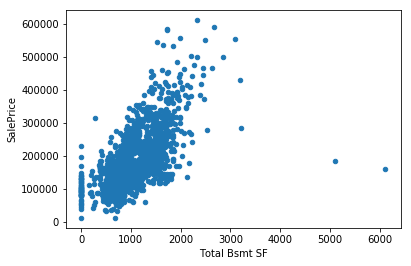

<Figure size 864x864 with 0 Axes>

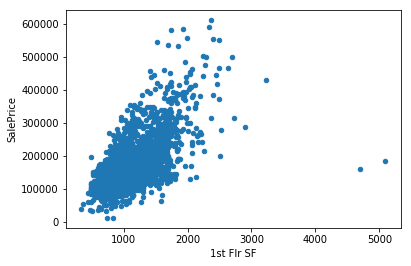

<Figure size 864x864 with 0 Axes>

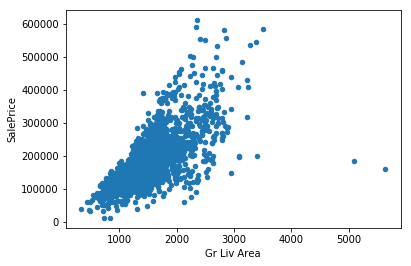

<Figure size 864x864 with 0 Axes>

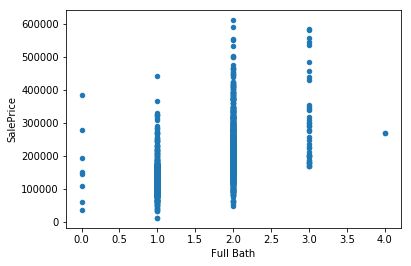

<Figure size 864x864 with 0 Axes>

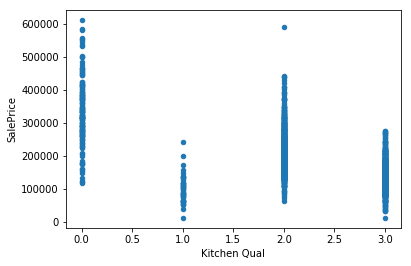

<Figure size 864x864 with 0 Axes>

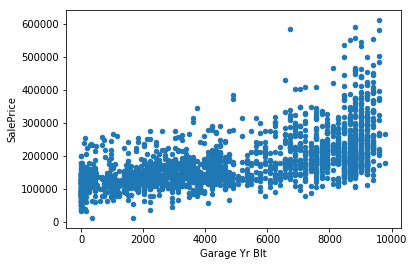

<Figure size 864x864 with 0 Axes>

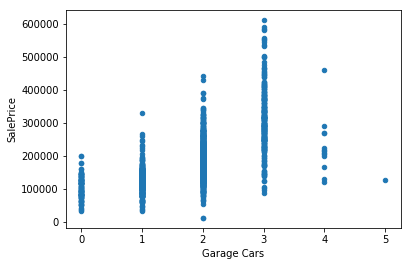

<Figure size 864x864 with 0 Axes>

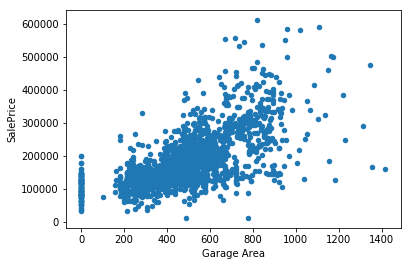

In [284]:
for col in most_correlated.index.tolist():
    if col!= 'SalePrice':
        plt.figure(figsize=(12,12))
        df.plot(kind="scatter", x=col, y="SalePrice")

## 3. Modeling

This is where the fun begins... I think the features above are the best features. Will try a few things out to see how I can lower the RMSE.

In [285]:
features = most_correlated.index.tolist()
features.remove('SalePrice')

X = df[features]
y = df['SalePrice']

X_train,X_test, y_train, y_test = train_test_split(X, y)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [286]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_train_scaled, y_train)

0.8074756457182808

In [315]:
mean_squared_error(y_train, lr.predict(X_train_scaled))

1213475368.0919983

In [288]:
lr.score(X_test_scaled, y_test)

0.8617526175410395

In [316]:
mean_squared_error(y_train, lr.predict(X_train_scaled))

1213475368.0919983

In [308]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.8907721609514904

In [309]:
mean_squared_error(y_train, rf.predict(X_train_scaled))

150012158.61685476

In [310]:
mean_squared_error(y_test, rf.predict(X_test_scaled))

637903006.2088171

In [311]:
clf = Lasso(alpha=.05,normalize=True, max_iter=1e5)
clf.fit(X_train_scaled,y_train)
clf.score(X_train_scaled,y_train)

0.8074756316075018

In [312]:
clf.score(X_test_scaled,y_test)

0.8617474838703508

In [313]:
mean_squared_error(y_test, clf.predict(X_test_scaled))

807410422.3179681

In [314]:
rr = Ridge(alpha=1,max_iter=1e5)
rr.fit(X_train_scaled,y_train)
rr.score(X_train_scaled,y_train)

0.8074754488883209

In [298]:
rr.score(X_test_scaled,y_test)

0.8617749103514727

In [299]:
mean_squared_error(y_test, rr.predict(X_test_scaled))

807250248.5480783

In [300]:
en = ElasticNet(alpha=.1,max_iter=1e5)
en.fit(X_train_scaled,y_train)
en.score(X_train_scaled,y_train)

0.8067646545641227

In [301]:
en.score(X_test_scaled,y_test)

0.8622244595760373

In [386]:
mean_squared_error(y_test, en.predict(X_test_scaled))

804624829.934227

In [387]:
gb = GradientBoostingRegressor()
gb.fit(X_train_scaled,y_train)
gb.score(X_train_scaled,y_train)

0.9438077098015394

In [388]:
gb.score(X_test_scaled,y_test)

0.8992604748160389

In [404]:
mean_squared_error(y_test, gb.predict(X_test_scaled))

588330287.577675

In [ ]:
parameters = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': np.linspace(0.1,1,10),
    'n_estimators': list(range(1, 1000, 50)),
    'max_depth':list(range(1, 10))
}
ngb = GradientBoostingRegressor()

gscv = GridSearchCV(ngb, parameters, cv=5)
gscv.fit(X_train_scaled,y_train)

In [ ]:
gscv.score(X_train_scaled,y_train)

In [ ]:
gscv.score(X_test_scaled,y_test)

In [305]:
# Plot predictions and how far off you are HERE

## Submit to Kaggle

In [402]:
# https://www.kaggle.com/dansbecker/submitting-from-a-kernel
# Read the test data
test = pd.read_csv('../data/test.csv')

# Zero out numbers
for col in test.select_dtypes("float64").columns.tolist():
    test[col].fillna(0, inplace=True)

for col in test.select_dtypes("float64").columns.tolist():
    test[col] = test[col].astype("int64")    

# Replace null String values
test['Mas Vnr Type'].fillna("None", inplace=True)

for val in string_cols:
    test[val].fillna("NA", inplace=True)

for col in test[features].select_dtypes('object').columns.tolist():
    le.fit(test[col].unique())
    test[col] = le.transform(test[col])

# Treat the test data in the same way as training data. In this case, pull same columns.
test_X = test[features]

scaled_test_X = ss.transform(test_X)

# Use the model to make predictions
predicted_prices = gb.predict(scaled_test_X)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})

my_submission

file_name = '../submissions/new_kaggle.csv'
my_submission.to_csv(file_name, index=False)

In [403]:
import subprocess, webbrowser
result = subprocess.check_output(f'kaggle competitions submit -f {file_name} -m "uploading a new set" dsi-us-5-project-2-regression-challenge')
if result == b'Successfully submitted to DSI-US-5 Project 2 Regression Challenge':
    webbrowser.open("https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge/leaderboard")
else:
    print(result)